<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек:" data-toc-modified-id="Импорт-библиотек:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек:</a></span></li><li><span><a href="#Обзор-данных:" data-toc-modified-id="Обзор-данных:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обзор данных:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Определеие-лага-для-сдвига:" data-toc-modified-id="Определеие-лага-для-сдвига:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Определеие лага для сдвига:</a></span></li><li><span><a href="#Определение-размера-окна-для-скользящего-среднего:" data-toc-modified-id="Определение-размера-окна-для-скользящего-среднего:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Определение размера окна для скользящего среднего:</a></span></li><li><span><a href="#Определение-признаков-для-моделей:" data-toc-modified-id="Определение-признаков-для-моделей:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Определение признаков для моделей:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия:" data-toc-modified-id="Линейная-регрессия:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия:</a></span></li><li><span><a href="#Случайный-лес:" data-toc-modified-id="Случайный-лес:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес:</a></span></li><li><span><a href="#Регрессия-Ridge:" data-toc-modified-id="Регрессия-Ridge:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Регрессия Ridge:</a></span></li><li><span><a href="#Регрессия-LGBM:" data-toc-modified-id="Регрессия-LGBM:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Регрессия LGBM:</a></span></li><li><span><a href="#Сравнительная-таблица:" data-toc-modified-id="Сравнительная-таблица:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Сравнительная таблица:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Регрессия-LGBM:" data-toc-modified-id="Регрессия-LGBM:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Регрессия LGBM:</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Согласно техническому заданию значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами.
4. Проверим данные на тестовой выборке и определим лучшую для представления заказчику.


Признаки:
- `datetime` - отрезок времени, по 10 минут
- `num_orders`Количество заказов за 1 отрезок времени `datetime`

## Подготовка

### Импорт библиотек:

In [1]:
import pandas as pd

import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge


from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

### Обзор данных:

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

<AxesSubplot:>

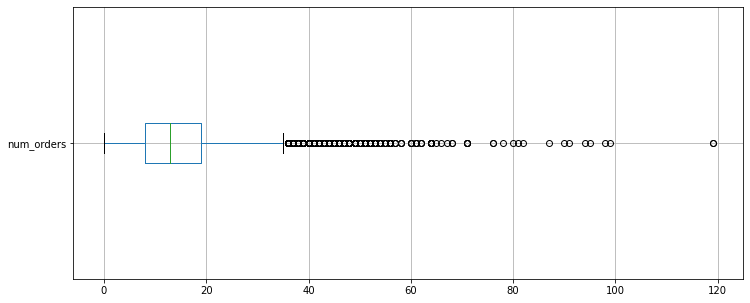

In [6]:
df.boxplot('num_orders', vert = False, figsize=(12,5))

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

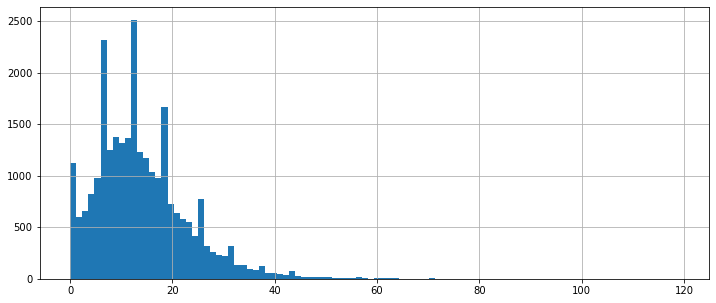

In [7]:
df['num_orders'].hist(bins=100, figsize=(12,5))
df['num_orders'].describe()

**Вывод** Выполнен обзор датасета. Датасет имеер размер 26496*2. Данные подготовленные: не имеют пропусков, типы данных соответствуют значениям. Распределение заказов распределено нормально и имеет положительную скошенность.

## Анализ

Проверим порядок расположения индексов на монотонность:

In [8]:
print(df.index.is_monotonic)

True


Клиент запрашивает прогнозирование на 1час. Соответственно ресемплируем данные по 1 часу и посмотрим на график:

In [9]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

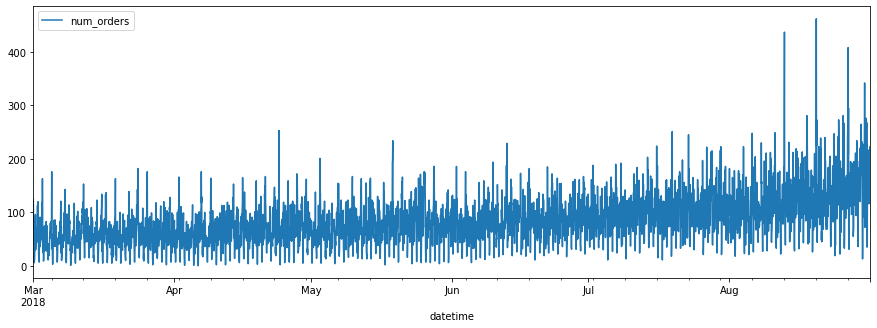

In [10]:
df.plot(figsize=(15,5))

Тренд числа заказов  - явно растет. Все больше людей используют сервис. Рассмотрим данные за неделю:

<AxesSubplot:xlabel='datetime'>

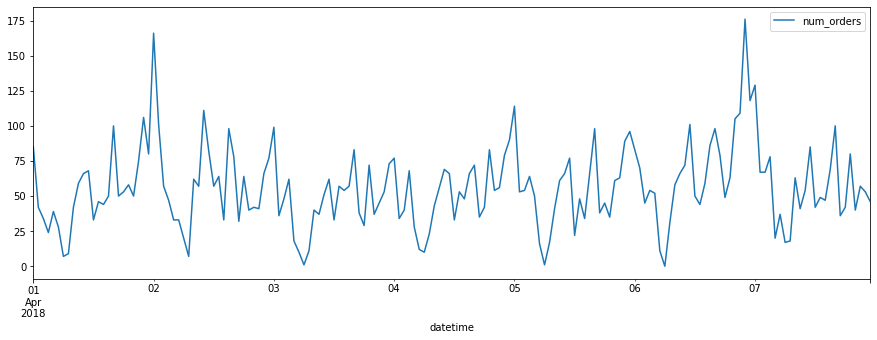

In [11]:
df['2018-04-01':'2018-04-07'].plot(figsize=(15,5))

<AxesSubplot:xlabel='datetime'>

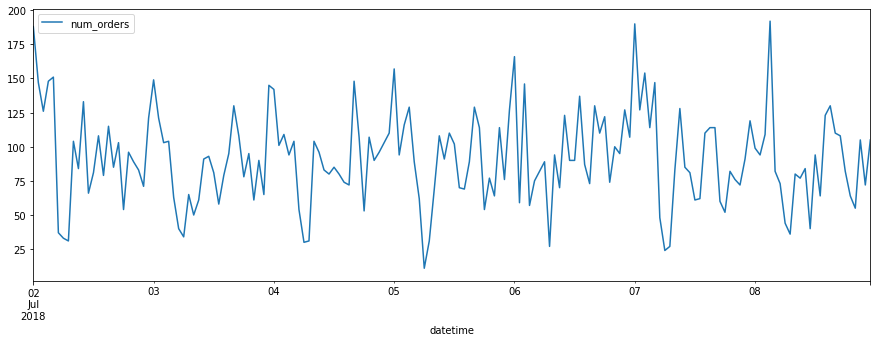

In [12]:
df['2018-07-02':'2018-07-08'].plot(figsize=(15,5))

На примере двух недель к полуночи наблюдается сезонное увеличение числа заказов с последующим спадом к минимуму в предутреннее время.

Text(0.5, 1.0, 'Residuals')

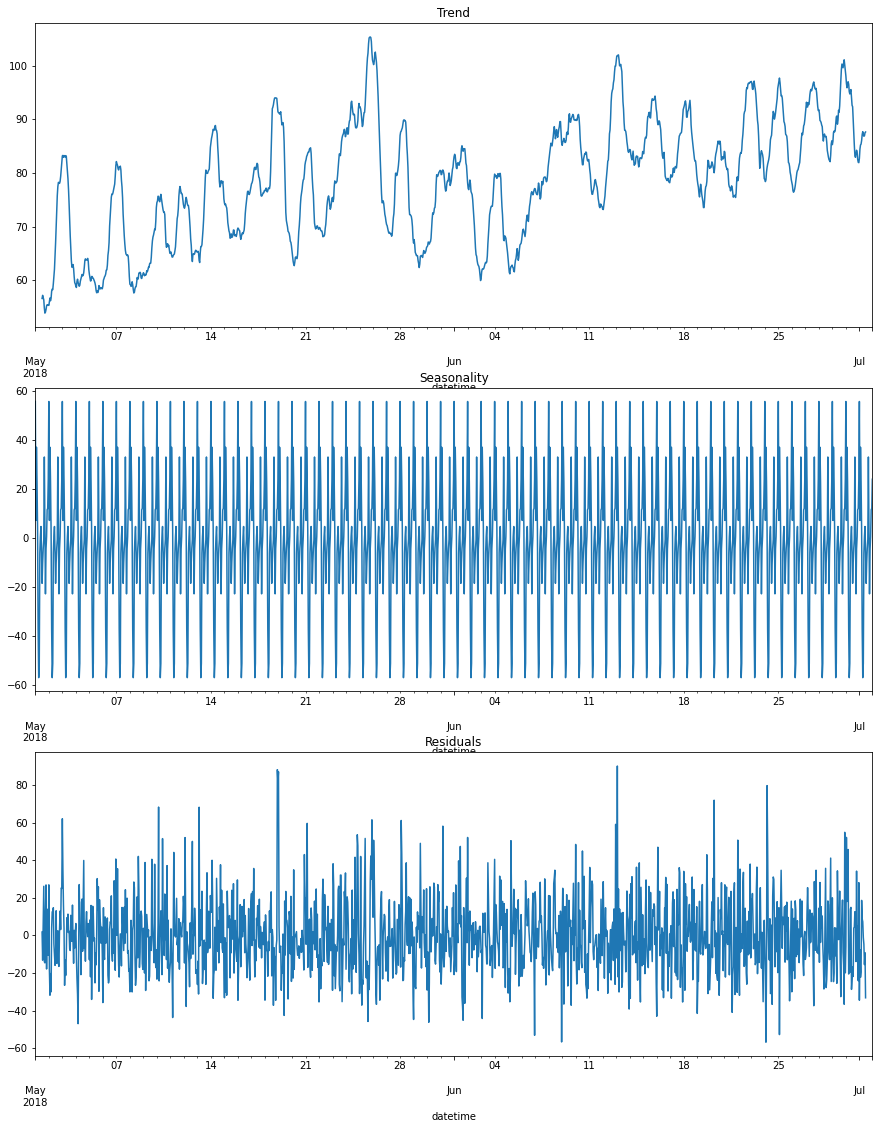

In [13]:
decomposed = seasonal_decompose(df['2018-05-01':'2018-07-01'])
plt.figure(figsize=(15,19))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')

Временной ряд нестационарный: дисперсия со временем увеличивается. Для возможности прогнозирования требуется сделать ряд стационарным.

### Определеие лага для сдвига:

Построим график автокорреляции для определения максимального лага:

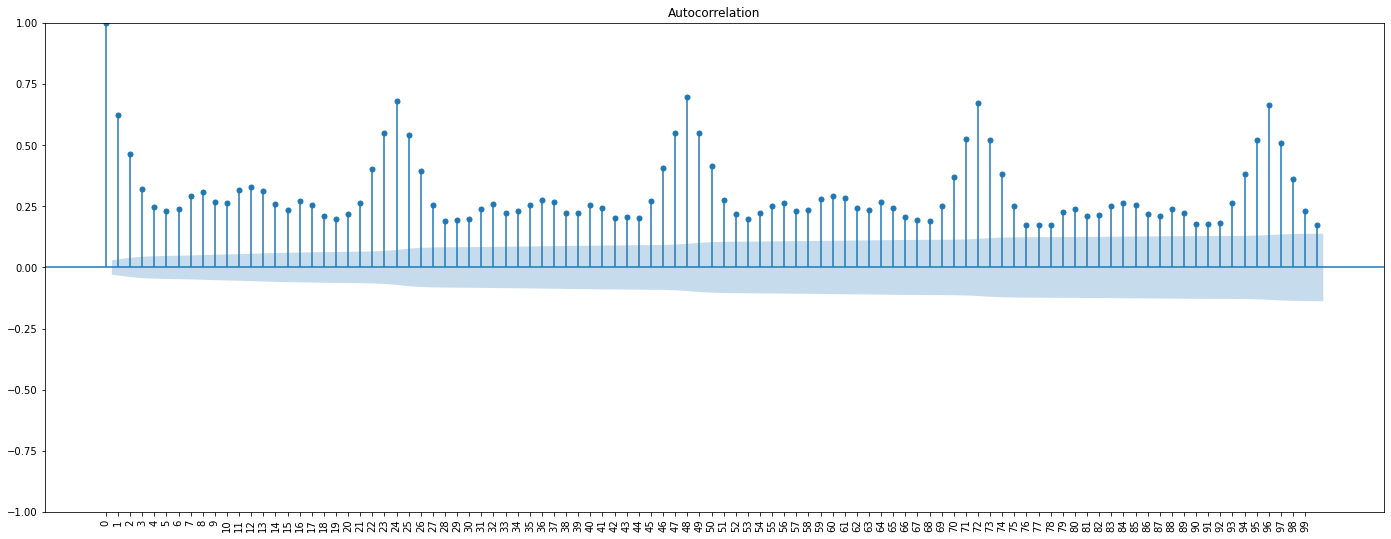

In [14]:
time_list = df['num_orders']
lags = 100
plt.figure(figsize=(24,9))
plt.xticks(list(range(lags)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)


In [15]:
max_lag = 24

Максимальная корреляция временного ряда наблюдается каждые 24 дня. Выберем это значение в качестве параметра `max_lag`=24.

### Определение размера окна для скользящего среднего:

Создадим словарь, в котором ключами будут размеры окна, а значениями - RMSE между количеством заказов и скользящим средним:

In [16]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(1,49):
    data = df['2018-08-30':'2018-08-31'].copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    #plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    #plt.show()
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    print(f'RMSE for "rolling_mean_size"={rolling_mean_size} : {round(RMSE,2)} orders')
    rolling_mean_size_dict[rolling_mean_size] = RMSE

RMSE for "rolling_mean_size"=1 : 0.0 orders
RMSE for "rolling_mean_size"=2 : 37.21 orders
RMSE for "rolling_mean_size"=3 : 53.29 orders
RMSE for "rolling_mean_size"=4 : 63.74 orders
RMSE for "rolling_mean_size"=5 : 67.6 orders
RMSE for "rolling_mean_size"=6 : 69.73 orders
RMSE for "rolling_mean_size"=7 : 67.92 orders
RMSE for "rolling_mean_size"=8 : 62.93 orders
RMSE for "rolling_mean_size"=9 : 59.29 orders
RMSE for "rolling_mean_size"=10 : 60.04 orders
RMSE for "rolling_mean_size"=11 : 62.15 orders
RMSE for "rolling_mean_size"=12 : 63.27 orders
RMSE for "rolling_mean_size"=13 : 64.52 orders
RMSE for "rolling_mean_size"=14 : 65.52 orders
RMSE for "rolling_mean_size"=15 : 66.57 orders
RMSE for "rolling_mean_size"=16 : 66.39 orders
RMSE for "rolling_mean_size"=17 : 66.79 orders
RMSE for "rolling_mean_size"=18 : 65.96 orders
RMSE for "rolling_mean_size"=19 : 59.95 orders
RMSE for "rolling_mean_size"=20 : 61.62 orders
RMSE for "rolling_mean_size"=21 : 60.3 orders
RMSE for "rolling_mean_siz

rolling_mean_size_dict

Минимальное значение RMSE 30.93 зафиксировано при `rolling_mean_size`= 33

### Определение признаков для моделей:

Подготовим функцию для создания признаков для обучения моделей:

In [17]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [18]:
data_taxi_copy = df.copy()
make_features(df,'num_orders', max_lag, 1)

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=282)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Подготовим функцию для расчета метрики RMSE:

In [19]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits


In [20]:
df.shape

(4416, 29)

In [21]:
train.shape[0]

3950

Проверка бейслайн модели:

In [22]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)

27.529305439273667

## Обучение

### Линейная регрессия:

In [23]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = cv_time_series_rmse(regressor=regressor, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 27.529305439273667
CPU times: total: 62.5 ms
Wall time: 31.2 ms


Mean RMSE from CV of LinearRegression = 27.979648497831434
CPU times: user 45 ms, sys: 179 ms, total: 224 ms
Wall time: 148 ms

### Случайный лес:

Подбор параметров:

In [24]:
%%time

regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(10, 25, 2)]
hyperparams = [{'criterion':['squared_error'], 
                'max_depth':max_depth_list, 
                'n_estimators':[25, 50, 100, 125],
                'random_state':[282]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(best_params_RFR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()



# Tuning hyper-parameters for root_mean_squared_error

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters set found on development set:

{'criterion': 'squared_error', 'max_depth': 24, 'n_estimators': 125, 'random_state': 282}

Grid scores on development set:

25.399788 for {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 25, 'random_state': 282}
25.317926 for {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 50, 'random_state': 282}
25.261992 for {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 100, 'random_state': 282}
25.226841 for {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 125, 'random_state': 282}
25.360178 for {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 25, 'random_state': 282}
25.154115 for {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 50, 'random_state': 282}
25.067969 for {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 100, 'random_s

24.91 for {'criterion': 'squared_error', 'max_depth': 24, 'n_estimators': 125, 'random_state': 282}

Проверка:

In [25]:
%%time

regressor = RandomForestRegressor()
regressor.set_params(**best_params_RFR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_RFR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Mean RMSE from CV of RandomForestRegressor =', cv_RMSE_RFR)


# Train for root_mean_squared_error

Mean RMSE from CV of RandomForestRegressor = 27.43264986325575
CPU times: total: 16.3 s
Wall time: 16.6 s


Mean RMSE from CV of RandomForestRegressor = 27.43
CPU times: user 6.42 s, sys: 12.4 ms, total: 6.43 s
Wall time: 6.44 s

### Регрессия Ridge:

Подбор параметров:

In [26]:
%%time

regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100, 1000],
                'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg'],
               'random_state':[282]}]


print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_R = clf.best_params_
print(best_params_R)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()


# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'alpha': 1000, 'random_state': 282, 'solver': 'lsqr'}

Grid scores on development set:

26.144369 for {'alpha': 0.1, 'random_state': 282, 'solver': 'auto'}
26.144369 for {'alpha': 0.1, 'random_state': 282, 'solver': 'svd'}
26.144369 for {'alpha': 0.1, 'random_state': 282, 'solver': 'cholesky'}
26.144178 for {'alpha': 0.1, 'random_state': 282, 'solver': 'lsqr'}
26.144547 for {'alpha': 0.1, 'random_state': 282, 'solver': 'sparse_cg'}
26.144250 for {'alpha': 1, 'random_state': 282, 'solver': 'auto'}
26.144250 for {'alpha': 1, 'random_state': 282, 'solver': 'svd'}
26.144250 for {'alpha': 1, 'random_state': 282, 'solver': 'cholesky'}
26.144060 for {'alpha': 1, 'random_state': 282, 'solver': 'lsqr'}
26.144401 for {'alpha': 1, 'random_state': 282, 'solver': 'sparse_cg'}
26.143094 for {'alpha': 10, 'random_state': 282, 'solver': 'auto'}
26.143094 for {'alpha': 10, 'random_state': 282, 'solver

RMSE 26.198810 on Ridge with parameters{'alpha': 1000, 'solver': 'svd'}

Проверка:

In [27]:

%%time

regressor = Ridge()
regressor.set_params(**best_params_R)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_R = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
print('Mean RMSE from CV of Ridge =', cv_RMSE_R)


# Train for root_mean_squared_error

Mean RMSE from CV of Ridge = 27.62075767008942
CPU times: total: 46.9 ms
Wall time: 45.9 ms


Mean RMSE from CV of Ridge = 28.22863681897381
CPU times: user 207 ms, sys: 539 ms, total: 746 ms
Wall time: 704 ms

### Регрессия LGBM:

In [28]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[282]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(best_params_LGBMR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 282}

Grid scores on development set:

24.517681 for {'learning_rate': 0.1, 'random_state': 282}
25.259306 for {'learning_rate': 0.2, 'random_state': 282}
25.524925 for {'learning_rate': 0.3, 'random_state': 282}
26.593219 for {'learning_rate': 0.4, 'random_state': 282}
27.365227 for {'learning_rate': 0.5, 'random_state': 282}

CPU times: total: 16.7 s
Wall time: 4.27 s


In [29]:
%%time

regressor = LGBMRegressor()
regressor.set_params(**best_params_LGBMR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LGBMR = cv_time_series_rmse(regressor=regressor, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Mean RMSE from CV of LGBMRegressor =', cv_RMSE_LGBMR)

# Train for root_mean_squared_error

Mean RMSE from CV of LGBMRegressor = 27.30927927327383
CPU times: total: 1.69 s
Wall time: 456 ms


Mean RMSE from CV of LGBMRegressor = 27.510281469422267
CPU times: user 2.84 s, sys: 36.1 ms, total: 2.88 s
Wall time: 2.89 s

### Сравнительная таблица:

In [30]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'RidgeRegression',
         'LGBMRegressor']

data = {'RMSE на CV, шт./ час':[cv_RMSE_LR,
                            cv_RMSE_RFR,
                            cv_RMSE_R,
                            cv_RMSE_LGBMR]
       }
        
pivot = pd.DataFrame(data=data, index=index)
pivot.sort_values(by='RMSE на CV, шт./ час')

,"RMSE на CV, шт./ час"
LGBMRegressor,27.309279
RandomForestRegressor,27.432650
LinearRegression,27.529305
RidgeRegression,27.620758


## Тестирование

### Регрессия LGBM:

CPU times: total: 1.31 s
Wall time: 421 ms


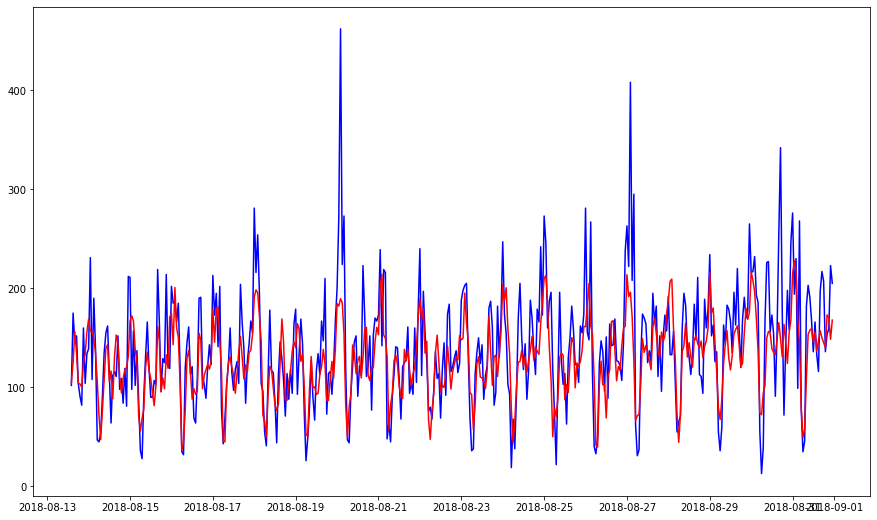

In [33]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBMR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=(15,9))
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

In [34]:
final_RMSE_LGBMR

42.0262109766554

### Вывод:
1. Исследованы 4 модели на предмет размера ошибки предскзания количества заказов на следующий день
2. По результатам итогового тестирования для предоставления заказчику отобрана модель LGBMRegressor с ошибкой = 42 заказа/час